In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

In [10]:
# 1) Carregar os dados
# =====================
path_dataset = 'dataset.csv'
path_just_features = 'just_features.csv'
dataset = pd.read_csv(path_dataset)
just_features = pd.read_csv(path_just_features)

In [11]:
# 2) Remoção de duplicatas e tratamento inicial
# =====================
dataset = dataset.drop_duplicates()
just_features = just_features.drop_duplicates()

# Identificação de colunas categóricas e numéricas
categorical_cols = ['genero', 'estado_civil', 'zona_residencia', 'fumador', 'class_etaria']
numeric_cols = ['imc']

# Normalização
scaler = MinMaxScaler()
dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])
just_features[numeric_cols] = scaler.transform(just_features[numeric_cols])

# Codificação One-Hot
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_dataset = encoder.fit_transform(dataset[categorical_cols])
encoded_just_features = encoder.transform(just_features[categorical_cols])

# Converter para DataFrame
encoded_columns = encoder.get_feature_names_out(categorical_cols)
encoded_dataset = pd.DataFrame(encoded_dataset, columns=encoded_columns, index=dataset.index)
encoded_just_features = pd.DataFrame(encoded_just_features, columns=encoded_columns, index=just_features.index)

# Concatenar dados codificados
X = pd.concat([dataset[numeric_cols], encoded_dataset], axis=1)
y = dataset['custo']
X_just_features = pd.concat([just_features[numeric_cols], encoded_just_features], axis=1)

In [12]:
X

,imc,genero_masculino,estado_civil_separado,estado_civil_solteiro,estado_civil_viuvo,zona_residencia_suburbana,zona_residencia_urbana,fumador_sim,class_etaria_adulto_jovem,class_etaria_adulto_meia_idade,class_etaria_adulto_senior,class_etaria_idoso,class_etaria_jovem
0,0.406524,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.450439,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.468005,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.311167,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.347553,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,0.401506,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2211,0.332497,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2212,0.284818,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2213,0.304893,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


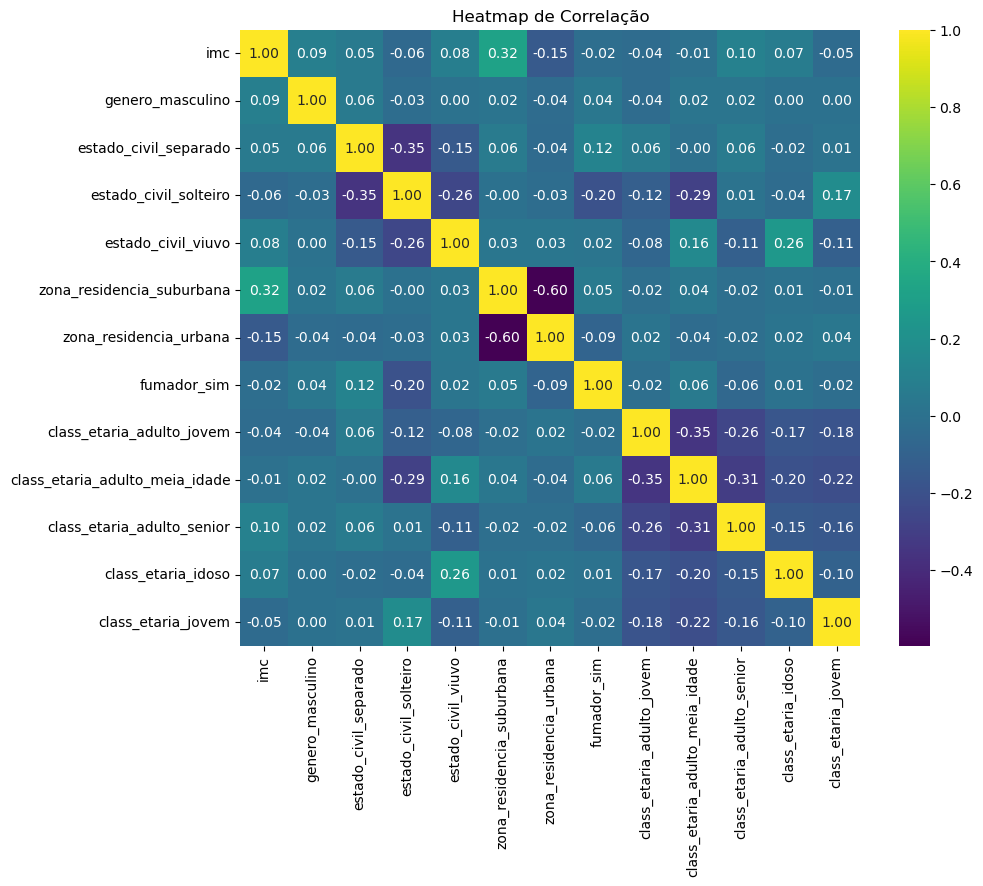

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sns
corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Heatmap de Correlação")
plt.show()

In [13]:
# 3) Balanceamento Manual da Variável Alvo
# =====================
# Discretizar a variável alvo em bins
bins = pd.qcut(y, q=10, duplicates='drop')
dataset['custo_bin'] = bins

# Aplicar oversampling para balanceamento
balanced_data = []
for group in dataset['custo_bin'].unique():
    group_data = dataset[dataset['custo_bin'] == group]
    balanced_group = resample(group_data, replace=True, n_samples=int(len(dataset) / len(dataset['custo_bin'].unique())), random_state=42)
    balanced_data.append(balanced_group)

balanced_data = pd.concat(balanced_data)
X = pd.concat([balanced_data[numeric_cols], encoded_dataset.loc[balanced_data.index]], axis=1)
y = balanced_data['custo']

# Remover a coluna de bins após balanceamento
X = X.drop(columns=['custo_bin'], errors='ignore')


In [ ]:
# 4) Divisão em conjuntos de treino e teste
# =====================
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Configuração do modelo SVM e ajuste de hiperparâmetros
svr = SVR()
param_grid = {
    'kernel': ['rbf', 'linear'],  # Adicionando mais kernels
    'C': [0.1, 1, 10, 100],  # Expandindo o intervalo de C
    'gamma': [0.001, 0.01, 0.1, 1]  # Expandindo o intervalo de gamma
}
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_  # Aqui é onde o modelo é atribuído

# 3) Previsão no conjunto de características "just_features"
previsao_scaled = best_model.predict(X_just_features)

# 4) Inversão da normalização da variável alvo
previsao = scaler_y.inverse_transform(previsao_scaled.reshape(-1, 1))

# 5) Exemplo de como acessar a previsão da primeira entrada (por exemplo, `yteste.iloc[0]`)
y_test.iloc[0]

KeyError: 0

In [15]:
# 5) Avaliação do Modelo
# =====================
r2 = r2_score(X_test, y_test)
print(f"R2: {r2:.4f}")

ValueError: y_true and y_pred have different number of output (13!=1)